In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<h1>MLB Baseball Sweep Analysis</h1>

Copyright (C) 2021 Scott Boston (scott.boston@yahoo.com)  
No part of this code nor logic maybe used without permission of the copyright owner.

Property of Scott Boston   
Author: Scott Boston   
Date: April 27, 2021

Datasource: http://sportsbookreviewonline.com


What percentage of the time do teams convert a sweep of a 2 games or greater series?   For instances, in a three game series, the home team has won the first two games, what percentage of time does the winning team go on to win the last game of a series to convert the sweep opportunity?  I speculated that most of times teams do not go on complete the sweep.   I was wrong.  By analyzing the past eleven years of baseball records, I determined that sweep converts a little better than 54% of time over the past eleven seasons.  Can we devise an strategy to beat the money line?

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [3]:
def getGamesDataFrame(df, year):
    ''' Pivots source datarframe to return games dataframe '''

    # source datafrome
    # df = pd.read_excel('https://www.sportsbookreviewsonline.com/scoresoddsarchives/mlb/mlb%20odds%202011.xlsx')
    df = df.dropna(how="all").copy()

    df["Date"] = df["Date"].astype(int)  # To handle excel float type in some years
    df["Date"] = pd.to_datetime(
        f"{year}" + df["Date"].astype(str).str.rjust(4, "0"), format="%Y%m%d"
    )

    cols = ["Date", "VH", "Team", "Final", "Close"]
    df = df[cols]

    df = df[df["VH"].isin(["V", "H"])]

    # Flatten teams lines in to games
    df["Game No"] = (df["VH"] == "V").cumsum()
    df = df.set_index(["Game No", "Date", "VH"]).unstack()
    df.columns = df.columns.map("_".join)

    df = df.reset_index()

    # Define a series, if the same home and away teams have a date differ by more than two days
    # then increment series identifier
    df["Date Diff"] = df.groupby(["Team_H", "Team_V"])["Date"].diff()
    df.loc[df["Date Diff"] > pd.Timedelta(days=2), "Date Diff"] = np.nan
    df["Series"] = df.sort_values(["Team_H", "Team_V"])["Date Diff"].isna().cumsum()

    df = df.sort_values(["Team_H", "Team_V", "Date"])

    # Home team won or Away team won
    df["Home_Win"] = df["Final_V"] < df["Final_H"]

    # Assign Favorite Betting Team and odds Favorite
    df = df.assign(
        Favorite=np.select(
            [df["Close_H"] > df["Close_V"], df["Close_H"] < df["Close_V"]],
            ["Away", "Home"],
            "Toss up",
        )
    )

    # Look for potential sweep series
    l1 = lambda x: (x.iloc[:-1].sum() == 0) | (x.iloc[:-1].sum() == x.iloc[:-1].count())
    l1.__name__ = "Potential_Sweep"

    # Success sweep occurred
    l2 = lambda x: (x.sum() == 0) | (x.sum() == x.count())
    l2.__name__ = "Sweep"
    df = df.merge(
        df.groupby("Series").agg(
            Potential_Sweep=pd.NamedAgg(column="Home_Win", aggfunc=l1),
            Sweep=pd.NamedAgg(column="Home_Win", aggfunc=l2),
            Home_Away_Sweep=pd.NamedAgg(
                column="Home_Win", aggfunc=lambda x: "Home" if x.iloc[0] else "Away"
            ),
            No_Games_In_Series=pd.NamedAgg(column="Home_Win", aggfunc='count')
        ),
        left_on="Series",
        right_index=True,
    )
    return df


def getSeriesDataFrame(df, min_no=1, max_no=7):
    ''' Returns a dataframe with last game of each series where number of games in the series meets min and max values'''
    return df.query(f'{min_no} <= No_Games_In_Series <= {max_no}').drop_duplicates("Series", keep="last")


def getSweepDataFrame(df):
    ''' Returns a dataframe of only series with potential sweeps '''
    Sweep_df = df.loc[df["Potential_Sweep"]].copy()

    # Determines with team to bet on Home or away
    Sweep_df["BetOdds"] = np.where(
        Sweep_df["Home_Away_Sweep"] == "Home", Sweep_df["Close_H"], Sweep_df["Close_V"]
    )

    Sweep_df['Bet'] = np.where(Sweep_df["BetOdds"]<0, Sweep_df['BetOdds'],-100)

    #Sweep_df['Bet_Favorite'] = np.where(Sweep_df['Favorite'] == 'Home', Sweep_df['Close_H'], Sweep_df['Close_V'])

    # Betting logic on moneyline wagers
    cond = [
        (Sweep_df["BetOdds"] < 0) & Sweep_df["Sweep"],
        (Sweep_df["BetOdds"] < 0) & ~Sweep_df["Sweep"],
        (Sweep_df["BetOdds"] > 0) & Sweep_df["Sweep"],
        (Sweep_df["BetOdds"] > 0) & ~Sweep_df["Sweep"],
    ]
    res = [100, Sweep_df["BetOdds"], Sweep_df["BetOdds"], -100]

    Sweep_df["Bet_Outcome"] = np.select(cond, res)

    return Sweep_df


def plotBettingOutcomes(df, title, ax):
    for c in df:
        df[c].plot(
            ax=ax,
            markevery=[df[c].last_valid_index()],
            marker="o",
            ms=10,
            alpha=0.8,
            markeredgecolor="k",
        )
    ax.set_title(title, size=24)
    fmt = "${x:,.0f}"
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    ax.legend()
    ax.axhline(color="r", alpha=0.8)
    return ax


def drawBetSweepOutcomes(sweepdf, year):
    fig, ax = plt.subplots(3, 1, figsize=(25, 10), gridspec_kw={'hspace':.3})

    df = (
        sweep_df.sort_values("Date")["Bet_Outcome"]
        .cumsum()
        .reset_index(drop=True)
        .to_frame()
    )
    title = "All Sweep Opportunities"
    plotBettingOutcomes(df, title, ax[0])

    df = (
        sweep_df.sort_values("Date")
        .loc[sweep_df["Home_Away_Sweep"] == "Home", "Bet_Outcome"]
        .cumsum()
        .reset_index(drop=True)
        .to_frame()
    )
    title = "Home Series Sweep Opportunities"
    plotBettingOutcomes(df, title, ax[1])

    df = (
        sweep_df.sort_values("Date")
        .loc[
            (sweep_df["Favorite"] == "Home") & (sweep_df["Home_Away_Sweep"] == "Home"),
            "Bet_Outcome",
        ]
        .reset_index(drop=True)
        .cumsum()
        .to_frame()
    )
    title = "Home Series Sweep and Home Favorite Opportunities"
    plotBettingOutcomes(df, title, ax[2])

    [i.grid(axis="y") for i in ax]
    plt.gcf().suptitle(f'MLB Baseball Season {year}', size=24)


Get one year's data (Of course let's pull 2017)

In [4]:
year = 2017
rawdf = pd.read_excel(f'https://www.sportsbookreviewsonline.com/scoresoddsarchives/mlb/mlb%20odds%20{year}.xlsx', usecols=range(17))

gamesdf = getGamesDataFrame(rawdf, year)

seriesdf = getSeriesDataFrame(gamesdf)

sweep_df = getSweepDataFrame(seriesdf)

In [5]:
rawdf.head()

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,Final,Open,Close
0,401,961,V,PIT,CKUHL,2,1,0,0,1,0,1,0,0,5,183,190
1,401,962,H,CUB,KHENDRICK,1,0,1,0,0,0,0,1,0,3,-205,-210
2,401,963,V,ATL,MFRIED-L,0,0,0,0,0,0,2,0,0,2,-105,117
3,401,964,H,PHI,ANOLA,1,0,1,0,0,0,0,0,0,3,-105,-127
4,401,965,V,ARI,MBUMGARNE-L,1,0,0,0,6,0,0,0,0,7,188,205


In [ ]:
gamesdf.sort_values('Team_H').head(10)

,Game No,Date,Team_H,Team_V,Final_H,Final_V,Close_H,Close_V,Date Diff,Series,Home_Win,Favorite,Potential_Sweep,Sweep,Home_Away_Sweep,No_Games_In_Series
100,101,2021-04-09,ARI,CIN,5,6,133,-143,NaT,1,False,Away,False,False,Away,3
111,112,2021-04-10,ARI,CIN,8,3,112,-122,1 days,1,True,Away,False,False,Away,3
124,125,2021-04-11,ARI,CIN,7,0,-102,-108,1 days,1,True,Away,False,False,Away,3
142,143,2021-04-12,ARI,OAK,5,9,115,-125,NaT,2,False,Away,True,True,Away,2
157,158,2021-04-13,ARI,OAK,5,7,-105,-105,1 days,2,False,Toss up,True,True,Away,2
125,126,2021-04-11,ATL,PHI,6,7,-163,153,1 days,5,False,Home,True,False,Home,3
110,111,2021-04-10,ATL,PHI,5,4,-134,124,1 days,5,True,Home,True,False,Home,3
99,100,2021-04-09,ATL,PHI,8,1,-125,115,NaT,5,True,Home,True,False,Home,3
174,175,2021-04-15,ATL,MIA,7,6,-157,147,1 days,4,True,Home,True,False,Away,4
165,166,2021-04-14,ATL,MIA,5,6,-250,220,1 days,4,False,Home,True,False,Away,4


In [ ]:
seriesdf.head()

,Game No,Date,Team_H,Team_V,Final_H,Final_V,Close_H,Close_V,Date Diff,Series,Home_Win,Favorite,Potential_Sweep,Sweep,Home_Away_Sweep,No_Games_In_Series
124,125,2021-04-11,ARI,CIN,7,0,-102,-108,1 days,1,True,Away,False,False,Away,3
157,158,2021-04-13,ARI,OAK,5,7,-105,-105,1 days,2,False,Toss up,True,True,Away,2
316,317,2021-04-25,ATL,ARI,0,7,-185,170,0 days,3,False,Home,False,False,Home,3
174,175,2021-04-15,ATL,MIA,7,6,-157,147,1 days,4,True,Home,True,False,Away,4
125,126,2021-04-11,ATL,PHI,6,7,-163,153,1 days,5,False,Home,True,False,Home,3


In [ ]:
sweep_df.head()

,Game No,Date,Team_H,Team_V,Final_H,Final_V,Close_H,Close_V,Date Diff,Series,Home_Win,Favorite,Potential_Sweep,Sweep,Home_Away_Sweep,No_Games_In_Series,BetOdds,Bet,Bet_Outcome
157,158,2021-04-13,ARI,OAK,5,7,-105,-105,1 days,2,False,Toss up,True,True,Away,2,-105,-105,100
174,175,2021-04-15,ATL,MIA,7,6,-157,147,1 days,4,True,Home,True,False,Away,4,147,-100,-100
125,126,2021-04-11,ATL,PHI,6,7,-163,153,1 days,5,False,Home,True,False,Home,3,-163,-163,-163
126,127,2021-04-11,BAL,BOS,9,14,130,-140,1 days,6,False,Away,True,True,Away,3,-140,-140,100
307,308,2021-04-25,BAL,OAK,8,1,113,-123,1 days,7,True,Away,True,False,Away,3,-123,-123,-123


What percent of the time does a team actually convert a sweep?

In [ ]:
sweep_df['Sweep'].mean()

0.5

In [ ]:
sweep_df['Sweep'].value_counts()

True     28
False    28
Name: Sweep, dtype: int64

In [ ]:
sweep_df = sweep_df.sort_values('Date')
sweep_df

,Game No,Date,Team_H,Team_V,Final_H,Final_V,Close_H,Close_V,Date Diff,Series,Home_Win,Favorite,Potential_Sweep,Sweep,Home_Away_Sweep,No_Games_In_Series,BetOdds,Bet,Bet_Outcome
31,32,2021-04-03,MIA,TAM,12,7,-104,-106,1 days,57,True,Away,True,False,Away,3,-106,-106,-106
40,41,2021-04-04,DET,CLE,3,9,120,-130,1 days,36,False,Away,True,False,Home,3,120,-100,-100
41,42,2021-04-04,BOS,BAL,3,11,-170,160,1 days,9,False,Home,True,True,Away,3,160,-100,160
43,44,2021-04-04,OAK,HOU,2,9,-116,106,1 days,72,False,Home,True,True,Away,4,106,-100,106
38,39,2021-04-04,SDG,ARI,1,3,-200,180,1 days,81,False,Home,True,False,Home,4,-200,-200,-200
42,43,2021-04-04,KAN,TEX,3,7,-160,150,1 days,45,False,Home,True,False,Home,3,-160,-160,-160
34,35,2021-04-04,PHI,ATL,2,1,102,-112,1 days,75,True,Away,True,True,Home,3,102,-100,102
67,68,2021-04-06,LAA,HOU,2,4,-108,-102,1 days,48,False,Home,True,False,Home,2,-108,-108,-108
77,78,2021-04-07,MIA,STL,0,7,105,-115,1 days,56,False,Away,True,True,Away,3,-115,-115,100
85,86,2021-04-07,NYY,BAL,3,4,-190,175,1 days,68,False,Home,True,False,Home,3,-190,-190,-190


In [ ]:
sweep_df.query('Home_Away_Sweep == "Home"').head()

,Game No,Date,Team_H,Team_V,Final_H,Final_V,Close_H,Close_V,Date Diff,Series,Home_Win,Favorite,Potential_Sweep,Sweep,Home_Away_Sweep,No_Games_In_Series,BetOdds,Bet,Bet_Outcome
40,41,2021-04-04,DET,CLE,3,9,120,-130,1 days,36,False,Away,True,False,Home,3,120,-100,-100
38,39,2021-04-04,SDG,ARI,1,3,-200,180,1 days,81,False,Home,True,False,Home,4,-200,-200,-200
42,43,2021-04-04,KAN,TEX,3,7,-160,150,1 days,45,False,Home,True,False,Home,3,-160,-160,-160
34,35,2021-04-04,PHI,ATL,2,1,102,-112,1 days,75,True,Away,True,True,Home,3,102,-100,102
67,68,2021-04-06,LAA,HOU,2,4,-108,-102,1 days,48,False,Home,True,False,Home,2,-108,-108,-108


In [ ]:
sweep_df.query('Home_Away_Sweep == "Home" and Favorite == "Home"')

,Game No,Date,Team_H,Team_V,Final_H,Final_V,Close_H,Close_V,Date Diff,Series,Home_Win,Favorite,Potential_Sweep,Sweep,Home_Away_Sweep,No_Games_In_Series,BetOdds,Bet,Bet_Outcome
38,39,2021-04-04,SDG,ARI,1,3,-200,180,1 days,81,False,Home,True,False,Home,4,-200,-200,-200
42,43,2021-04-04,KAN,TEX,3,7,-160,150,1 days,45,False,Home,True,False,Home,3,-160,-160,-160
67,68,2021-04-06,LAA,HOU,2,4,-108,-102,1 days,48,False,Home,True,False,Home,2,-108,-108,-108
85,86,2021-04-07,NYY,BAL,3,4,-190,175,1 days,68,False,Home,True,False,Home,3,-190,-190,-190
73,74,2021-04-07,CIN,PIT,11,4,-200,180,1 days,16,True,Home,True,True,Home,3,-200,-200,100
81,82,2021-04-07,BOS,TAM,9,2,-112,102,1 days,12,True,Home,True,True,Home,3,-112,-112,100
94,95,2021-04-08,CWS,KAN,6,0,-165,155,NaT,33,True,Home,True,True,Home,1,-165,-165,100
106,107,2021-04-10,NYM,MIA,0,3,-270,240,2 days,64,False,Home,True,False,Home,2,-270,-270,-270
122,123,2021-04-11,SFO,COL,4,0,-125,115,1 days,90,True,Home,True,True,Home,3,-125,-125,100
125,126,2021-04-11,ATL,PHI,6,7,-163,153,1 days,5,False,Home,True,False,Home,3,-163,-163,-163


What is the subcategories and potential profits by Home/Away Team sweeping and betting favorite?

In [ ]:
sweep_df.groupby(['Home_Away_Sweep', 'Favorite'])['Bet_Outcome'].agg(['sum','count'])

sum  count
Home_Away_Sweep Favorite            
Away            Away     -507     13
                Home      333     12
                Toss up   100      1
Home            Away      -64      7
                Home     -335     23

Let's look at bankroll requirements of a seasons of betting

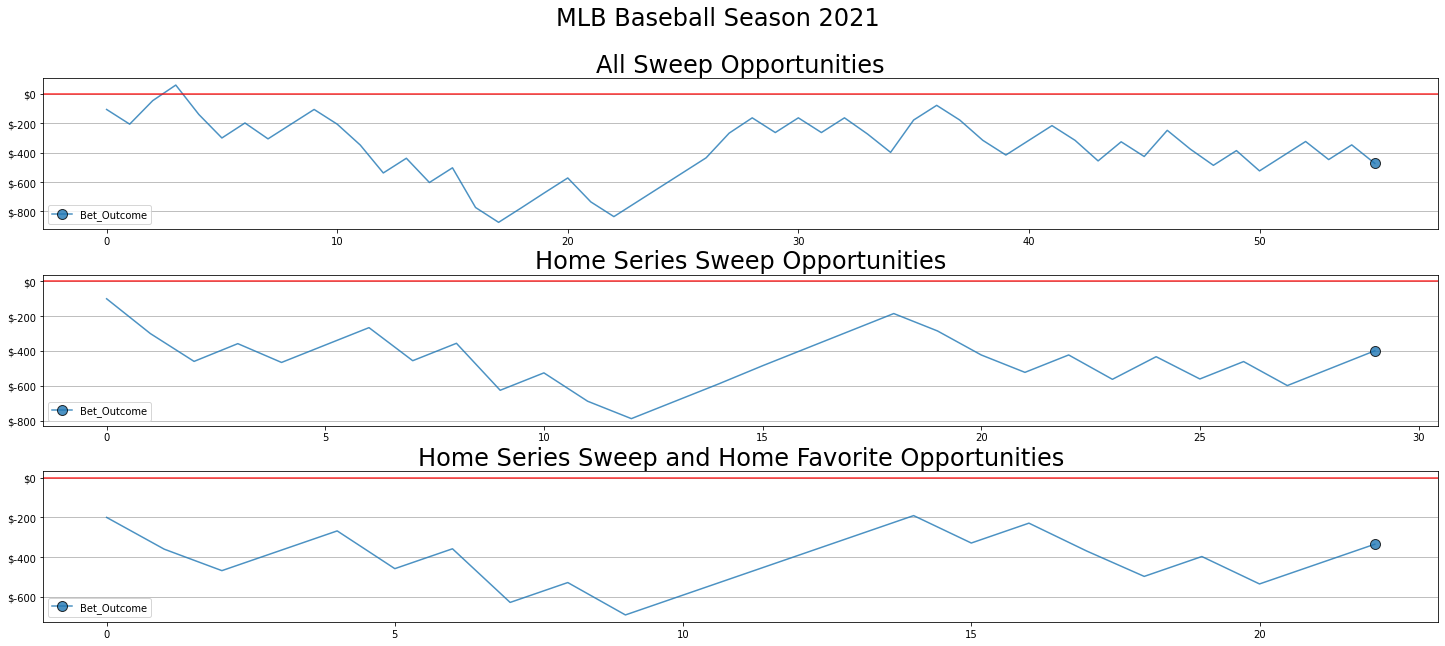

In [ ]:
drawBetSweepOutcomes(sweep_df, year)

Let's look at 11 seasons of data 2010 - 2021

In [ ]:
l={}
g={}
for s in range(2010, 2022):
    #print(s)
    rawdf = pd.read_excel(f'https://www.sportsbookreviewsonline.com/scoresoddsarchives/mlb/mlb%20odds%20{s}.xlsx')
    gamesdf = getGamesDataFrame(rawdf, s)
    seriesdf = getSeriesDataFrame(gamesdf)
    sweep_df = getSweepDataFrame(seriesdf)
    l[s] = sweep_df
    g[s] = gamesdf

In [ ]:
multiyear = pd.concat(l, keys=l.keys())
hws = pd.concat([d[d['Home_Away_Sweep'] == 'Home'] for k, d in l.items()], keys=l.keys())
bbs = pd.concat([d[(d['Favorite']=='Home')&(d['Home_Away_Sweep']=='Home')] for k, d in l.items()], keys=l.keys())
awafs = pd.concat([d[(d['Favorite'] == 'Away')&(d['Home_Away_Sweep'] == 'Away')] for k, d in l.items()], keys=l.keys())
sfcombo = pd.concat([bbs, awafs]).sort_index()

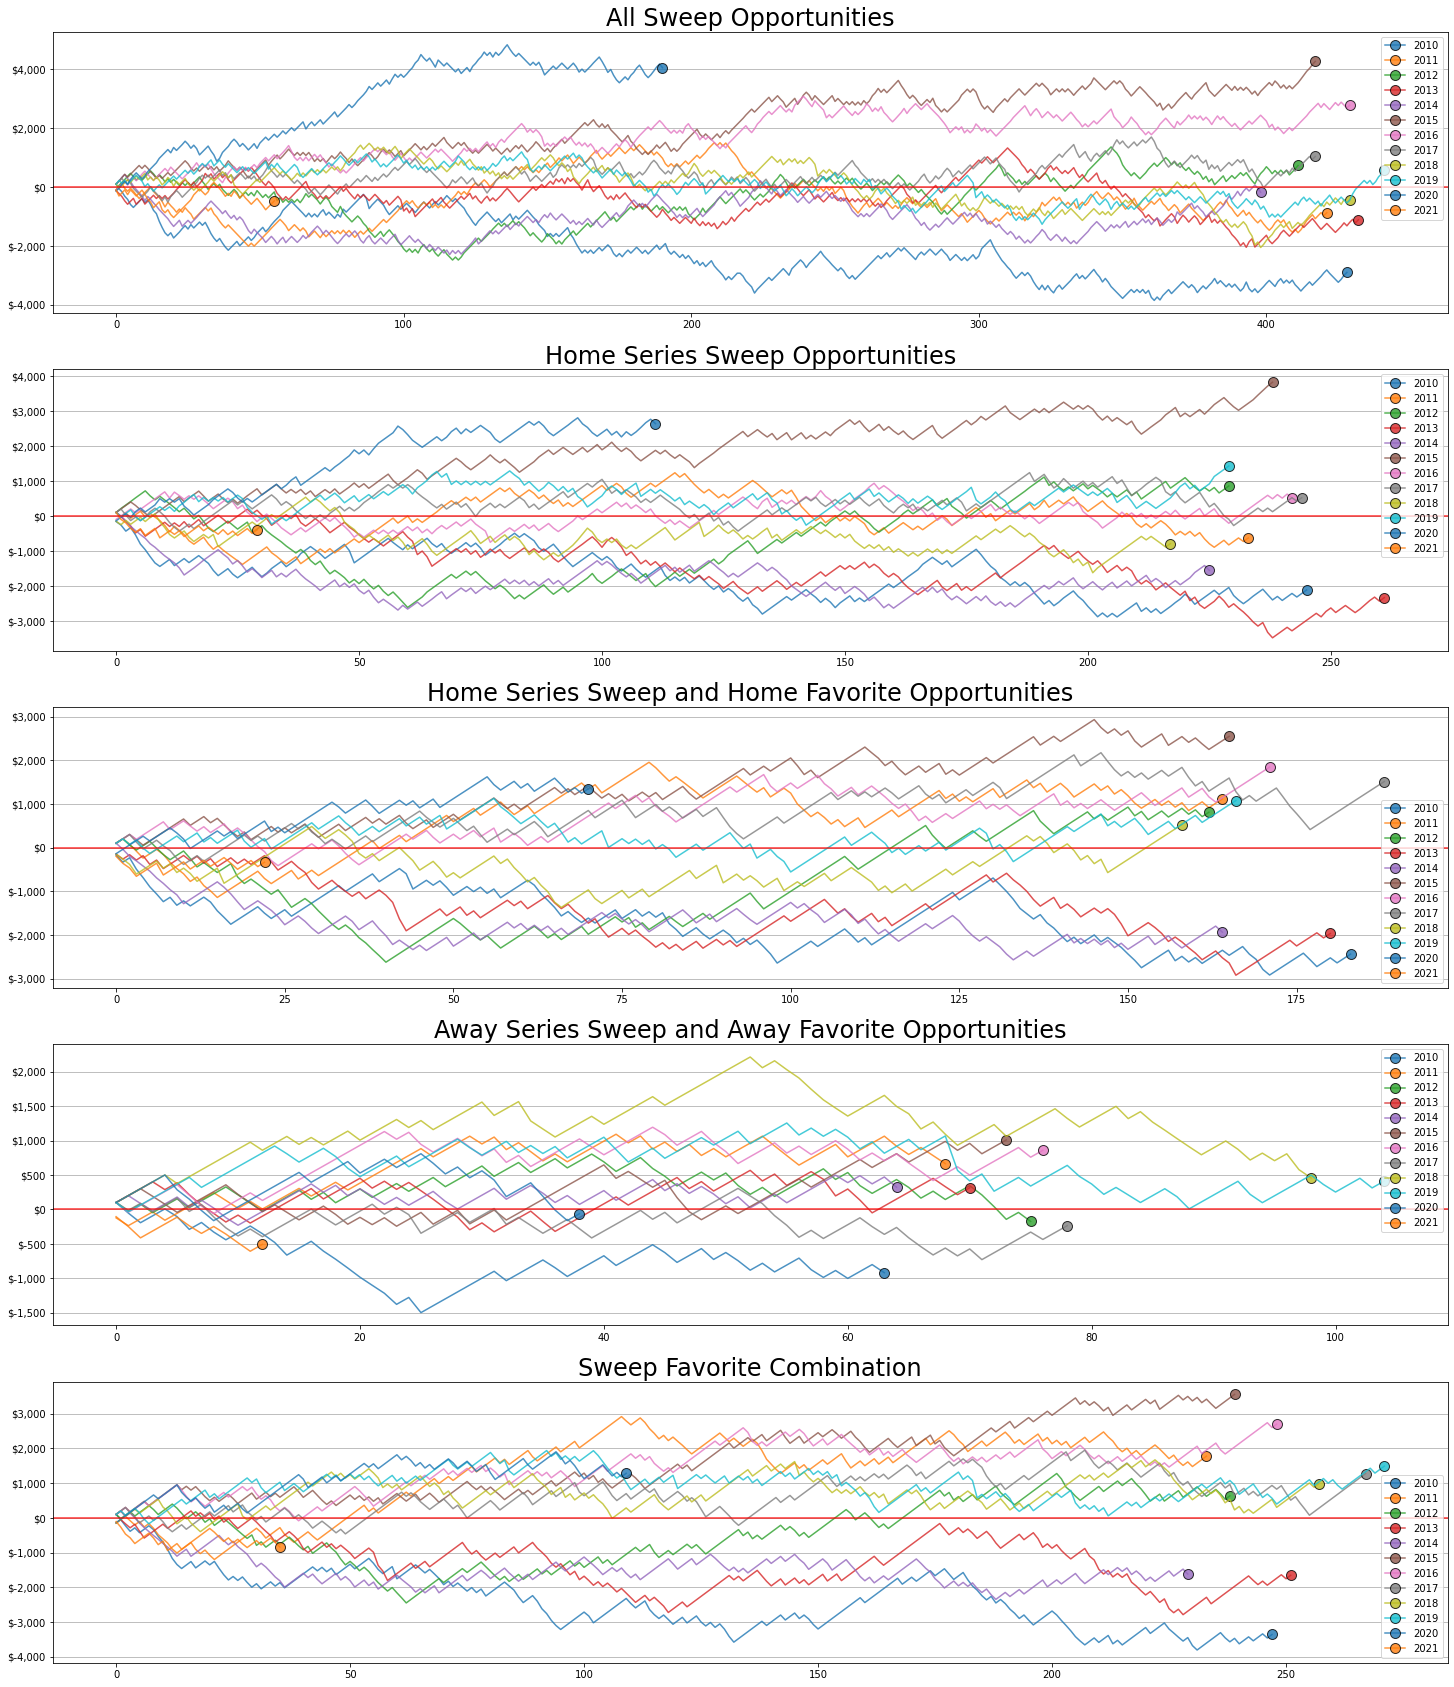

In [ ]:
def plotBettingScenario(df, title, ax):
    df = df.sort_values('Date')[['Bet_Outcome']].set_index(df.groupby(level=0).cumcount(), append=True)\
         .reset_index(level=1, drop=True)['Bet_Outcome'].unstack(0)\
         .cumsum()

    return plotBettingOutcomes(df, title, ax)

df_dict = {}
df_dict['All Sweep Opportunities'] = multiyear
df_dict['Home Series Sweep Opportunities'] = hws
df_dict['Home Series Sweep and Home Favorite Opportunities'] = bbs
df_dict['Away Series Sweep and Away Favorite Opportunities'] = awafs
df_dict['Sweep Favorite Combination'] = sfcombo

fig, ax = plt.subplots(len(df_dict),1, figsize=(25,30))
iax = iter(ax)
for title, df in df_dict.items():
    plotBettingScenario(df, title, next(iax))

_ = [i.grid(axis='y') for i in ax]

In [ ]:
def getAnalysis(multiyear):
    return multiyear.sort_values('Date')[['Bet_Outcome']].set_index(multiyear.groupby(level=0).cumcount(), append=True)\
         .reset_index(level=1, drop=True)['Bet_Outcome'].unstack(0)\
         .cumsum().agg(['min','count', lambda x: x.loc[x.last_valid_index()]]).T.rename(columns={'<lambda>':'ES Profit'})

df = pd.concat([getAnalysis(i) for i in df_dict.values()], 
              #  keys=['MultiYear', 'Home Sweep', 'Home Sweep Home Favorite Bet', 'Away Sweep Away Favorite Bet', 'Sweep Favorite Bet Combined']
               keys=df_dict.keys(), axis=1)
df.style.apply(lambda x: ['background: #98FB98']*len(x), subset=df.columns.get_loc_level('ES Profit', level=1)[0])

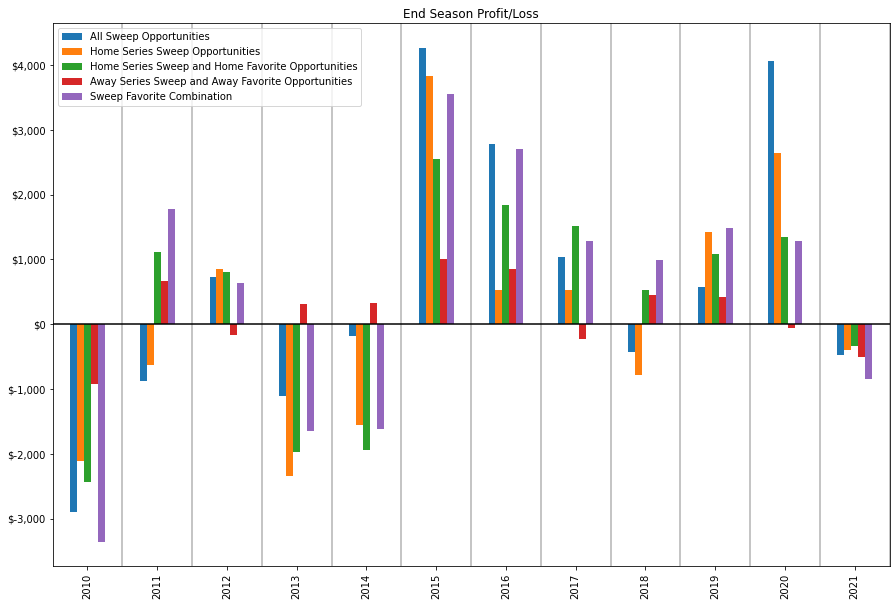

In [ ]:
ax = df.loc[:, pd.IndexSlice[:, 'ES Profit']].droplevel(level=1, axis=1).plot.bar(figsize=(15,10), title='End Season Profit/Loss')
fmt = "${x:,.0f}"
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.axhline(color='k')
_ = [ax.axvline(i, color='k', alpha=.3) for i in ax.get_xticks() + .5]

Results lead me to believe that it will be tough to defeat the money line on a consist basis, but there are some profitable seasons.



In [ ]:
multiyear['Sweep'].mean()

0.5439732142857143

In [ ]:
multiyear['Home_Win'].mean()

0.5348214285714286

Exploitable? Home Team

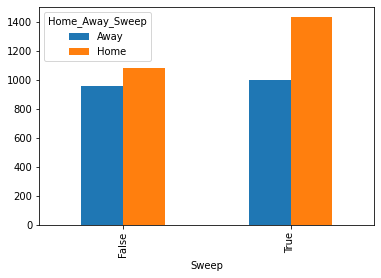

In [ ]:
multiyear.groupby(['Sweep', 'Home_Away_Sweep'])['Sweep'].count().unstack().plot.bar();

How about Home Team favorite and Home Team sweeping?

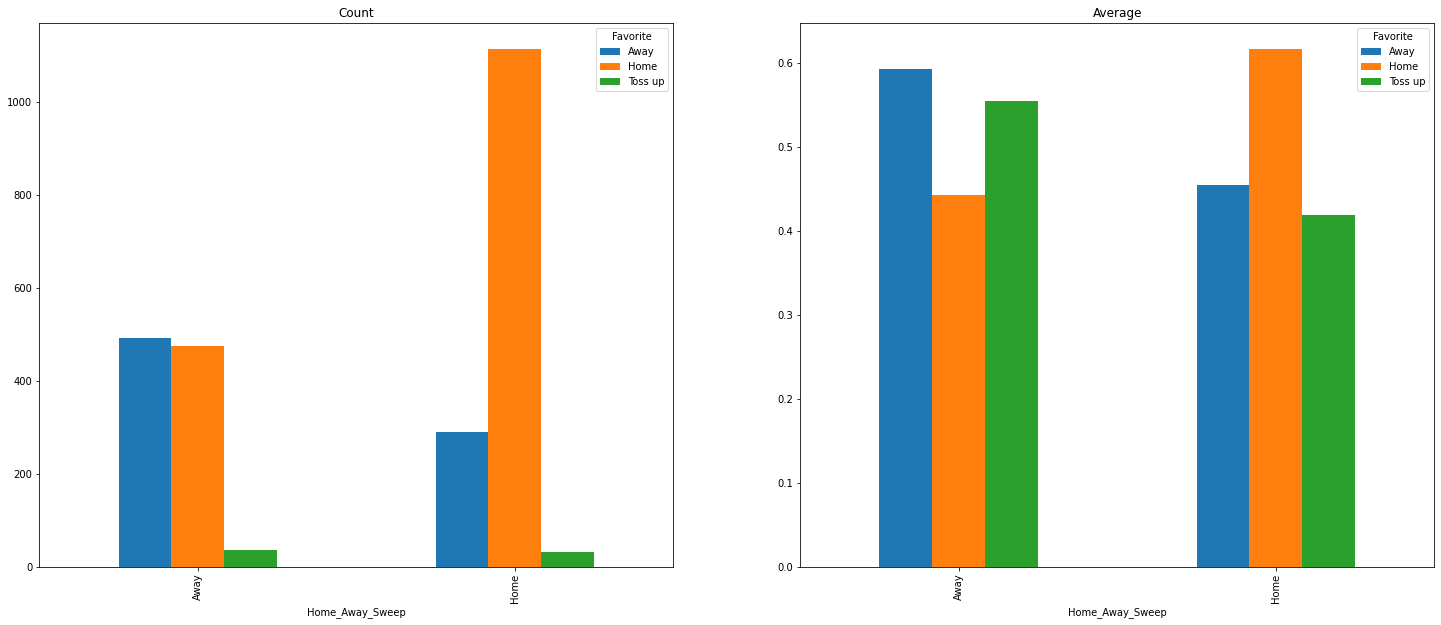

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(25,10))
multiyear.groupby(['Home_Away_Sweep', 'Favorite'])['Sweep'].sum().unstack().plot.bar(ax=ax[0], title='Count');
multiyear.groupby(['Home_Away_Sweep', 'Favorite'])['Sweep'].mean().unstack().plot.bar(ax=ax[1], title='Average');

In [ ]:
multiyear.loc[multiyear['Bet'] > 0, 'Sweep'].mean()

nan

How much bankroll need on any day with $100 bets?

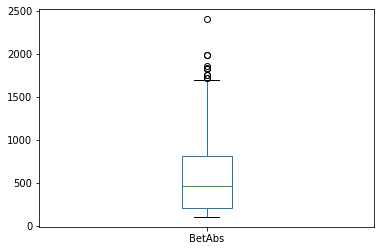

In [ ]:
multiyear.assign(BetAbs=multiyear['Bet'].abs()).groupby('Date')['BetAbs'].sum().plot.box()

In [ ]:
multiyear.groupby(['Home_Win', 'Favorite', pd.Grouper(freq='Y', key='Date')])['Bet_Outcome'].agg(['sum', 'count']).unstack()

sum             ...      count           
Date              2010-12-31 2011-12-31  ... 2020-12-31 2021-12-31
Home_Win Favorite                        ...                      
False    Away          549.0      667.0  ...       41.0        9.0
         Home        -6949.0    -3746.0  ...       46.0       16.0
         Toss up       482.0     -360.0  ...        1.0        1.0
True     Away        -1218.0    -1387.0  ...       38.0       11.0
         Home         4160.0     4329.0  ...       65.0       19.0
         Toss up        75.0     -375.0  ...        NaN        NaN

[6 rows x 24 columns]

In [ ]:
pm = multiyear.groupby(['Sweep','Home_Away_Sweep', 'Favorite'])['Game No'].count()
pm = multiyear.groupby(['Home_Away_Sweep', 'Favorite'])['Game No'].count()

In [ ]:
pm

Home_Away_Sweep  Favorite
Away             Away         831
                 Home        1071
                 Toss up       63
Home             Away         636
                 Home        1805
                 Toss up       74
Name: Game No, dtype: int64

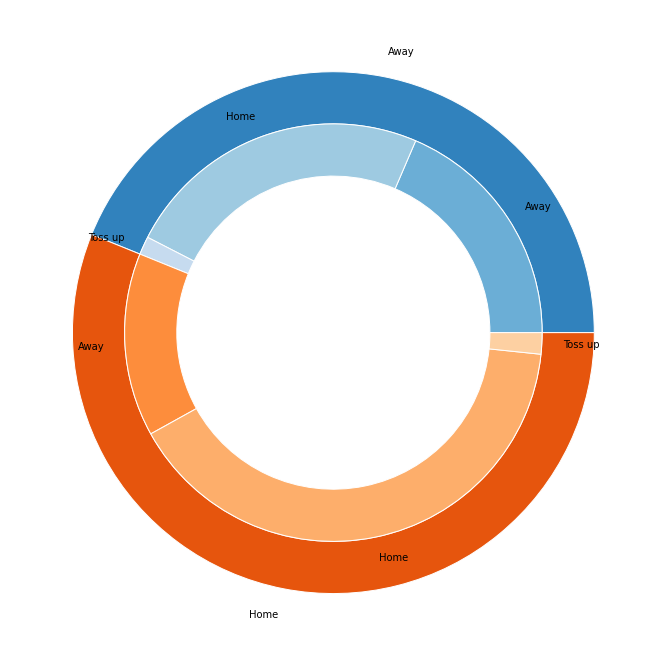

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))
cmap = plt.get_cmap('tab20c')
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 3, 5, 6, 7, 10]))


ax.pie(pm.sum(level=0).to_numpy().flatten(), radius=1, labels=pm.sum(level=0).index, colors=outer_colors,
       wedgeprops={'width':.2, 'edgecolor':'w'});
ax.pie(pm.sum(level=[0,1]).to_numpy().flatten(), radius=1-.2, labels=pm.sum(level=[0,1]).index.get_level_values(1), colors=inner_colors,
       wedgeprops={'width':.2, 'edgecolor':'w'});
# ax.pie(pm.to_numpy().flatten(), radius = 1-.2-.2, labels=pm.index.get_level_values(2), 
#       wedgeprops={'width':.2, 'edgecolor':'w'});

In [ ]:
multiyear.groupby('No_Games_In_Series')['Sweep'].mean()

No_Games_In_Series
1    1.000000
2    0.524116
3    0.519591
4    0.573059
5    0.500000
Name: Sweep, dtype: float64

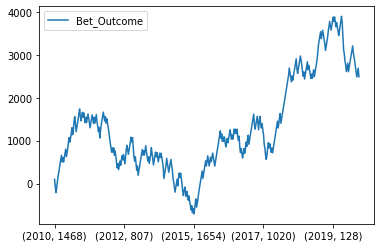

In [ ]:
four_games_series_df = multiyear.query('No_Games_In_Series == 4')
four_games_series_df[['Bet_Outcome']].cumsum().plot()

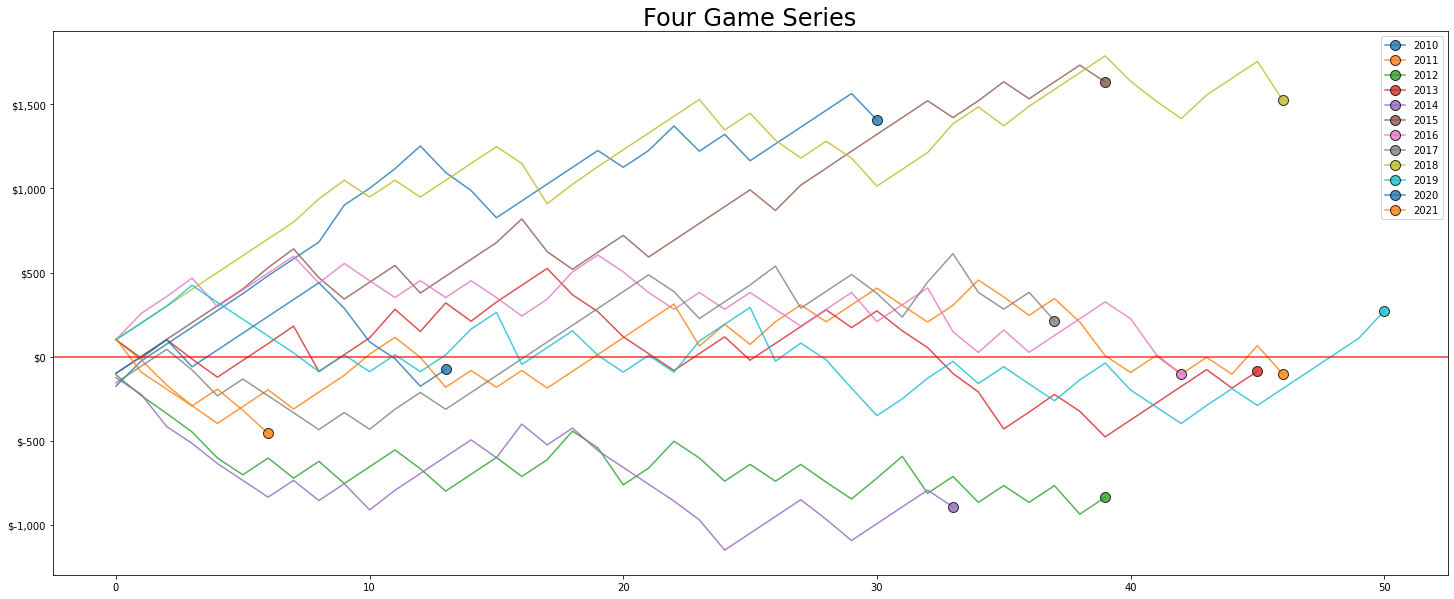

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
plotBettingScenario(four_games_series_df, 'Four Game Series', ax)

In [ ]:
hws

Game No       Date Team_H  ... BetOdds    Bet Bet_Outcome
2010 843       844 2010-06-06    ARI  ...   190.0 -100.0      -100.0
     1851     1851 2010-08-22    ARI  ...  -122.0 -122.0      -122.0
     2280     2280 2010-09-23    ARI  ...  -108.0 -108.0       100.0
     1412     1412 2010-07-21    ARI  ...  -130.0 -130.0       100.0
     1661     1661 2010-08-08    ARI  ...   134.0 -100.0      -100.0
...            ...        ...    ...  ...     ...    ...         ...
2021 38         39 2021-04-04    SDG  ...  -200.0 -200.0      -200.0
     245       246 2021-04-20    SEA  ...   175.0 -100.0      -100.0
     122       123 2021-04-11    SFO  ...  -125.0 -125.0       100.0
     302       303 2021-04-25    STL  ...  -125.0 -125.0       100.0
     128       129 2021-04-11    TAM  ...   128.0 -100.0      -100.0

[2515 rows x 19 columns]

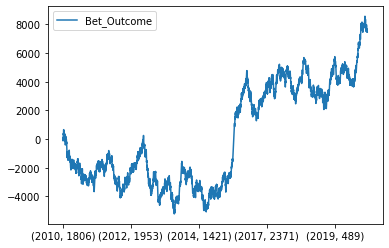

In [ ]:
multiyear[['Bet_Outcome']].cumsum().plot()

In [ ]:
bbs.groupby(level=0)['Bet_Outcome'].sum()

2010   -2439.0
2011    1114.0
2012     809.0
2013   -1967.0
2014   -1938.0
2015    2547.0
2016    1842.0
2017    1512.0
2018     527.0
2019    1077.0
2020    1345.0
2021    -335.0
Name: Bet_Outcome, dtype: float64

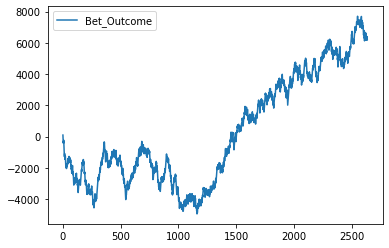

In [ ]:
sfcombo[['Bet_Outcome']].reset_index(drop=True).cumsum().plot()